In [5]:
import numpy as np
import matplotlib.pyplot as plt

from uot import UOT, EntRegUOT
from uot import exact_uot, exact_entreg_uot
from uot import calc_B, calc_f, calc_g
from sinkhorn import calc_R, calc_U, calc_k_stop, sinkhorn_entreg_uot, sinkhorn
from utils import norm_inf, get_distance_matrix

## Experiments

### Varying epsilon (Synthetic Data)

#### Preparation

In [ ]:
# Dimension
n = 10

# Regularization
tau = np.float128(5.0)

# Mass normalization
alpha = 2.0
beta = 4.0

# Number of eps
neps = 20

In [ ]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=50.0, size=(n, n)).astype(np.float128)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 1.0, size=n).astype(np.float128)
b = np.random.uniform(0.1, 1.0, size=n).astype(np.float128)

a = a / a.sum() * alpha
b = b / b.sum() * beta

#### Execution

In [ ]:
# Original UOT problem
uot = UOT(C, a, b, tau)

# Optimal solution
f_optimal, X_optimal = exact_uot(uot)

print('Optimal:', f_optimal)

In [ ]:
# Epsilons
eps_arr = np.linspace(start=1.0, stop=0.05, num=neps).astype(np.float128)

kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    # Entropic regularization parameter
    U = calc_U(uot, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    euot = EntRegUOT(C, a, b, tau, eta)

    # Sinkhorn
    _, log = sinkhorn_entreg_uot(euot, eps)

    # Find kf
    kf = log['k_stop']

    # Find kc
    f_approx = np.array([
        calc_f(uot, calc_B(euot, u, v))
        for u, v in zip(log['u'], log['v'])
    ])
    kc = np.where(f_approx - f_optimal > eps)[0][-1]

    kfs[i] = kf
    kcs[i] = kc + 1

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax[0].plot(eps_arr, np.log(kcs), label='\log k_f')
ax[0].plot(eps_arr, np.log(kfs), label='\log k_c')
ax[0].set_xlim(1.0 + 0.05, 0 - 0.05)

ax[1].plot(eps_arr, kfs / kcs, label='\log k_f')
ax[1].set_xlim(1.0 + 0.05, 0 - 0.05)

### Theory check (Synthetic data)

#### Preparation

In [ ]:
# Dimension
n = 100

# Regularization
tau = np.float128(1.0)
eta = np.float128(0.05)

# Number of Sinkhorn iterations
niters = 1000

In [ ]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=100.0, size=(n, n)).astype(np.float128)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 10.0, size=n).astype(np.float128)
b = np.random.uniform(0.1, 10.0, size=n).astype(np.float128)

Unbalanced OT

In [ ]:
uot = UOT(C, a, b, tau)

Solve UOT with CVXPY

In [ ]:
_, X_hat = exact_uot(uot)

Entropic UOT problem

In [ ]:
euot = EntRegUOT(C, a, b, tau, eta)

Solve Entropic UOT with CVXPY

In [ ]:
_, u_star, v_star = exact_entreg_uot(euot)

In [ ]:
X_star = calc_B(euot, u_star, v_star)
a_star = X_star.sum(-1)
b_star = X_star.sum(0)

Solve Entropic UOT with Sinkhorn iterations

In [ ]:
_, log = sinkhorn(euot, niters)

#### Convergence

In [ ]:
f_optimal = calc_f(uot, X_hat)
g_optimal = calc_g(euot, X_star)

In [ ]:
fs, gs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    Xk = calc_B(euot, uk, vk)
    fs[k] = calc_f(uot, Xk)
    gs[k] = calc_g(euot, Xk)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(range(niters + 1), fs - f_optimal)
ax[0].axhline(0, color='red')
ax[0].set_ylim(-0.01, 0.1)
ax[0].set_title(f'$f(X^*) - f(X^k)$ (min = {np.min(fs - f_optimal):.10f})')

ax[1].plot(range(niters + 1), gs - g_optimal)
ax[1].axhline(0, color='red')
ax[1].set_ylim(-0.01, 0.1)
ax[1].set_title(f'$g(X^*) - g(X^k)$ (min = {np.min(gs - g_optimal):.10f})')

plt.show()

In [ ]:
dus, dvs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    dus[k] = norm_inf(uk - u_star)
    dvs[k] = norm_inf(vk - v_star)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(range(niters + 1), dus)
ax[0].axhline(0, color='red')
ax[0].set_ylim(-0.01, 0.1)
ax[0].set_title(f'$||u^* - u_{{k}}||_\infty$ (min = {np.min(dus):.10f})')

ax[1].plot(range(niters + 1), dvs)
ax[1].axhline(0, color='red')
ax[1].set_ylim(-0.01, 0.1)
ax[1].set_title(f'$||v^* - v_{{k}}||_\infty$ (min = {np.min(dvs):.10f})')

plt.show()

#### Lemma 1

$$
\frac{u^*}{\tau} = \log(a) - \log(a^*) \\
\frac{v^*}{\tau} = \log(b) - \log(b^*)
$$

In [ ]:
print(norm_inf(u_star / tau - np.log(a / a_star)))

plt.plot(u_star / tau - np.log(a / a_star))
plt.show()

In [ ]:
print(norm_inf(v_star / tau - np.log(b / b_star)))

plt.plot(v_star / tau - np.log(b / b_star))
plt.show()

#### Lemma 2

$$
\Big| \log\left( \frac{a_i^*}{a_i^k} \right) -  \frac{u_i^* - u_i^k}{\eta}\Big| \leq  \max_{1 \leq j \leq n} \frac{|v^*_j - v^{k}_j|}{\eta}
$$

$$
\Big| \log\left( \frac{b_j^*}{b_j^k} \right) -  \frac{v_j^* - v_j^k}{\eta}\Big| \leq  \max_{1 \leq i \leq n} \frac{|u^*_i - u^{k}_i|}{\eta}
$$

In [ ]:
lhs, rhs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(euot, uk, vk)
    ak = X.sum(-1)

    l = norm_inf(np.log(a_star / ak) - (u_star - uk) / eta)
    r = norm_inf((v_star - vk) / eta)

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.show()

In [ ]:
lhs, rhs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(euot, uk, vk)
    bk = X.sum(0)

    l = norm_inf(np.log(b_star / bk) - (v_star - vk) / eta)
    r = norm_inf((u_star - uk) / eta)

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.show()

#### Lemma 3

$$
\max \{ \|u^*\|_{\infty},\|v^*\|_\infty \} \le \tau R
$$

In [ ]:
R = calc_R(euot)

In [ ]:
lhs = max(norm_inf(u_star), norm_inf(v_star))
rhs = tau * R
print(lhs - rhs)

#### Lemma 4

$$
g(X^*) + (2 \tau + \eta) x^* = \tau (\alpha + \beta) \\
f(\hat{X}) + 2 \tau \hat{x} = \tau (\alpha + \beta)
$$

In [ ]:
alpha, beta = a.sum(), b.sum()

In [ ]:
lhs1 = calc_g(euot, X_star) + (2 * tau + eta) * np.sum(X_star)
lhs2 = calc_f(uot, X_hat) + 2 * tau * np.sum(X_hat)
rhs = tau * (alpha + beta)
print(lhs1 - rhs)
print(lhs2 - rhs)

#### Theorem 1

$$
\max \{ \| u^{k} -  u^*\|_\infty, \| v^{k} -  v^*\|_\infty \} \le \Big( \frac{\tau}{\tau + \eta} \Big)^k \times \tau \times R
$$

In [ ]:
R = calc_R(euot)

In [ ]:
lhs = np.maximum(np.max(np.abs(log['u'] - u_star), -1), np.max(np.abs(log['v'] - v_star), -1))
rhs = (tau / (tau + eta)) ** np.arange(niters + 1) * tau * R

print((lhs > rhs).mean())

plt.figure(figsize=(12, 8))
plt.hist(lhs - rhs)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.axhline(0, c='r')
plt.show()

#### Corollary 2

$$
    \sum_{i, j = 1}^n X^*_{ij} \leq \left(\dfrac{1}{2} + \dfrac{\eta \log n}{2 \tau - 2\eta \log n}\right)(\alpha + \beta) + \dfrac{1}{6 \log n}
$$

In [ ]:
lhs = X_star.sum()
rhs = (0.5 + (eta * np.log(n)) / (2 * tau - 2 * eta * np.log(n))) * (alpha + beta) + 1 / (6 * np.log(n))

print(lhs, rhs, lhs - rhs)

$$
    \sum_{i, j = 1}^n \hat{X}_{ij} \leq \dfrac{\alpha + \beta}{2}
$$

In [ ]:
lhs = X_hat.sum()
rhs = (alpha + beta) / 2

print(lhs, rhs, lhs - rhs)

In [ ]:
y1, y2 = [], []

for k in range(2, niters, 2):
    y1.append(norm_inf(log['v'][k] - v_star) / norm_inf(log['u'][k+1] - u_star))
    y2.append(norm_inf(log['u'][k-1] - u_star) / norm_inf(log['v'][k] - v_star))

plt.figure(figsize=(12, 8))
plt.plot(y1)
plt.plot(y2)
plt.axhline((tau + eta) / tau, color='red')
plt.show()

### Varying epsilon (Real Data)

In [6]:
from mnist import load_mnist

x, y = load_mnist('data', split_type='train', download=True)

In [7]:
npairs = 10
pairs = [
    (3, 5), 
    (20562, 12428),
    (2564, 12380),
    (48485, 7605),
    (26428, 42698),
    (6152, 25061),
    (13168, 7506),
    (40816, 39370), 
    (846, 16727), 
    (31169, 7144)
]

In [8]:
n = 28

C = get_distance_matrix(n).astype(np.float64)

tau = np.float64(10.0)

In [9]:
fs = np.empty(npairs)
Xs = np.empty((npairs, n ** 2, n ** 2))

for i, (id1, id2) in enumerate(pairs):
    print(f'Pair [{id1:5d}] and [{id2:5d}]')
    a = x[id1].reshape(-1).astype(np.float64)
    b = x[id2].reshape(-1).astype(np.float64)

    a = a.clip(1e-6)
    b = b.clip(1e-6)

    fs[i], Xs[i] = exact_uot(UOT(C, a, b, tau))
    print('Done!')

Pair [    3] and [    5]


/home/vltanh/miniconda3/envs/ot/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done!
Pair [20562] and [12428]
Done!
Pair [ 2564] and [12380]
Done!
Pair [48485] and [ 7605]
Done!
Pair [26428] and [42698]
Done!
Pair [ 6152] and [25061]
Done!
Pair [13168] and [ 7506]
Done!
Pair [40816] and [39370]
Done!
Pair [  846] and [16727]
Done!
Pair [31169] and [ 7144]
Done!


Pair [    3] and [    5]


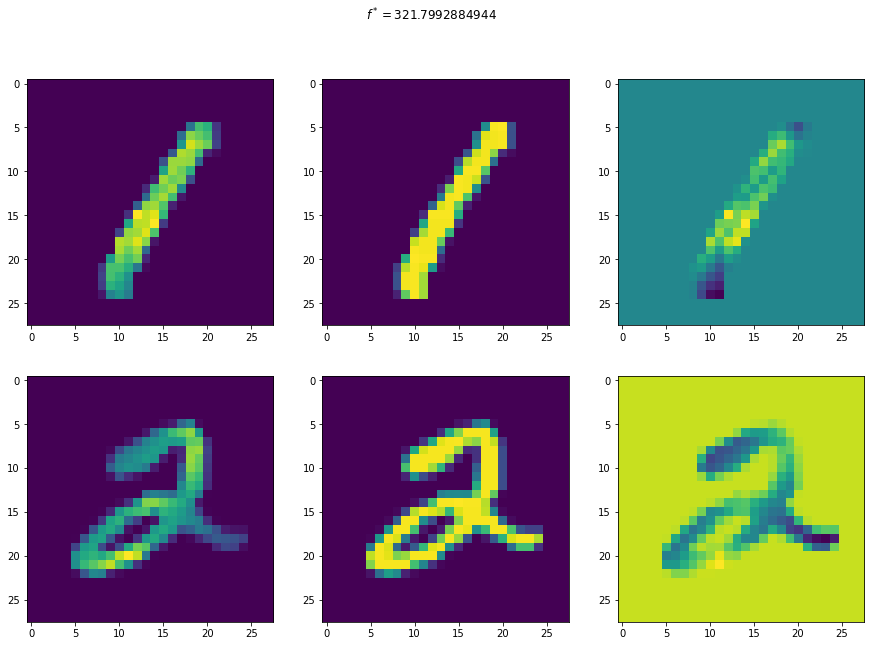

Pair [20562] and [12428]


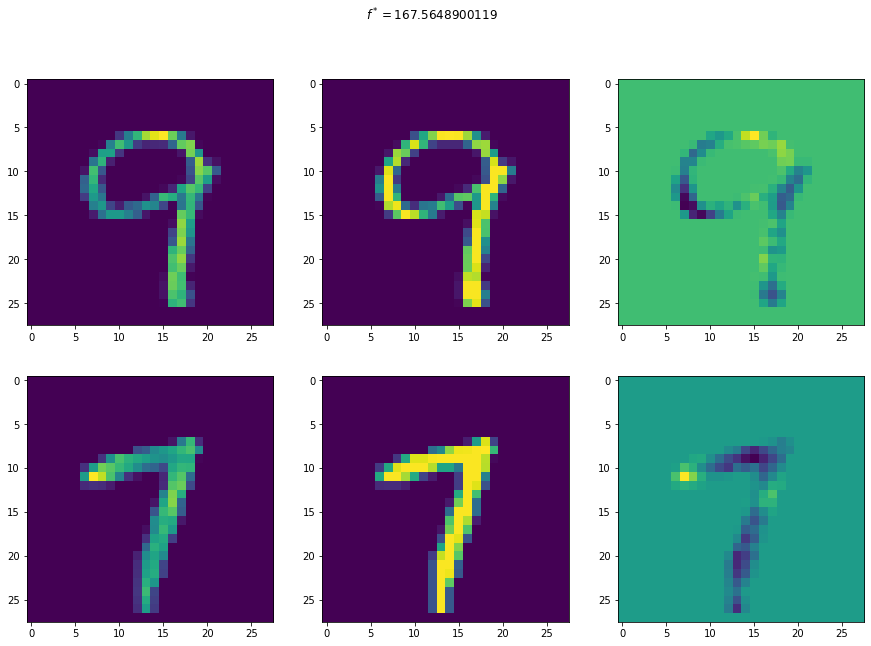

Pair [ 2564] and [12380]


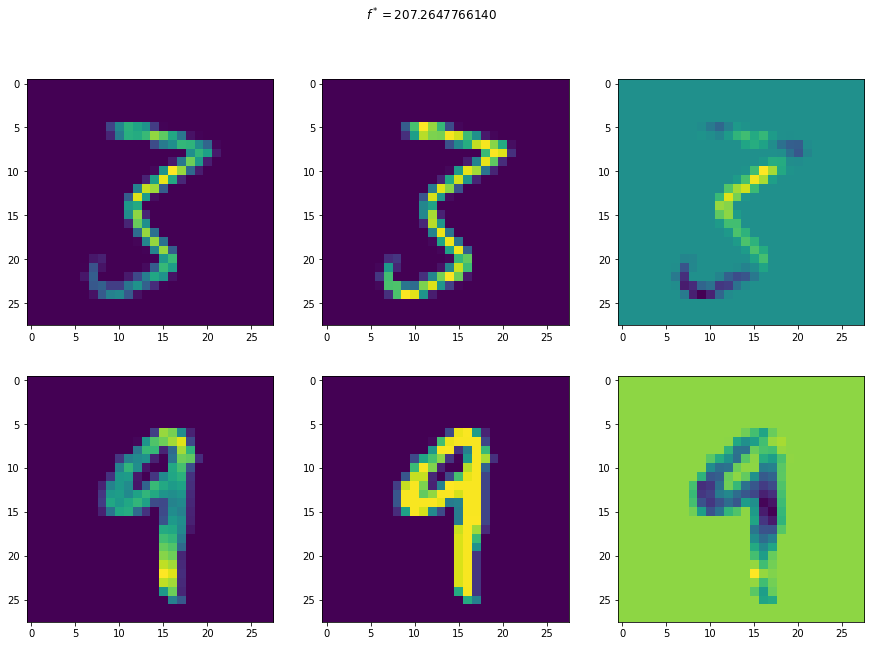

Pair [48485] and [ 7605]


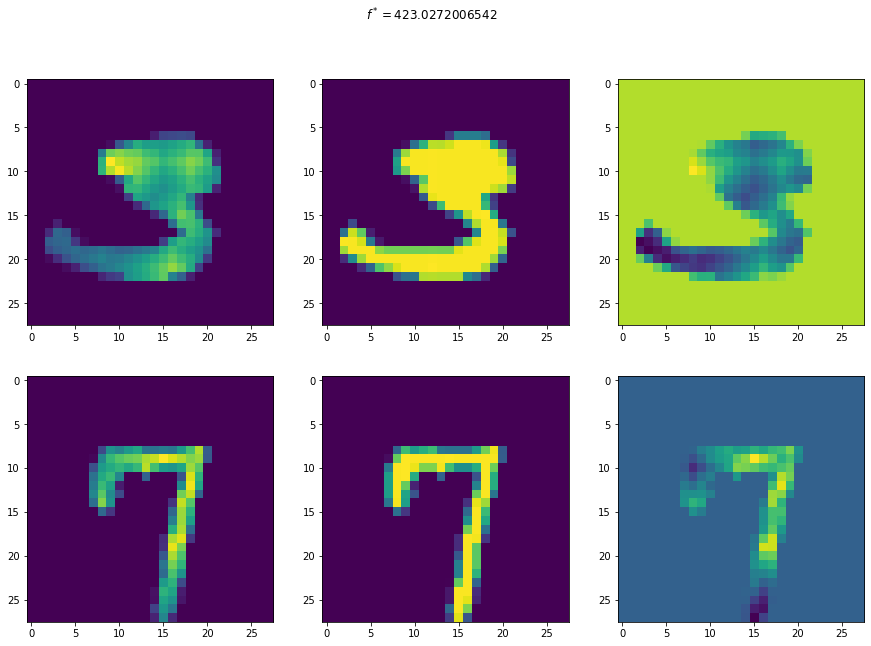

Pair [26428] and [42698]


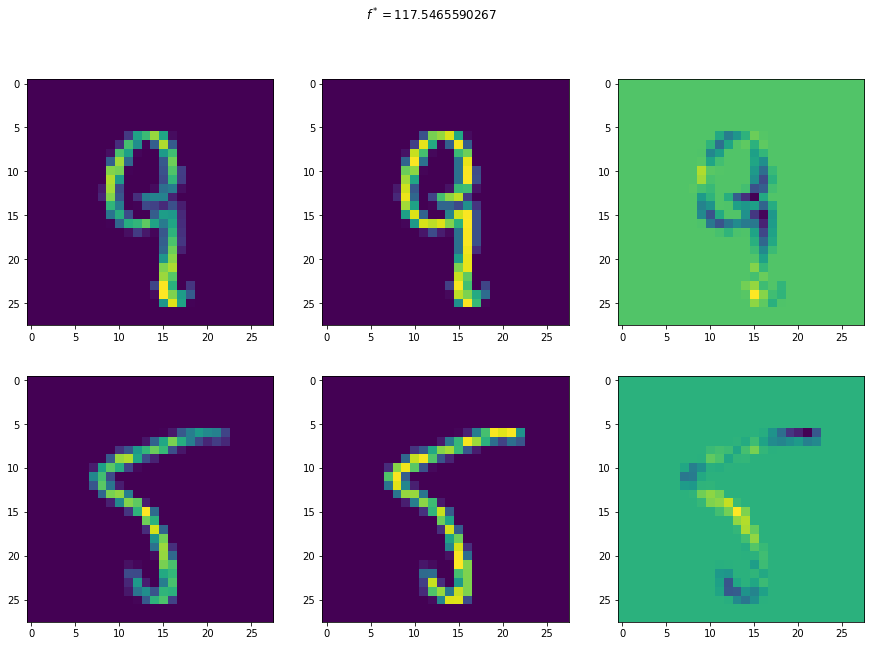

Pair [ 6152] and [25061]


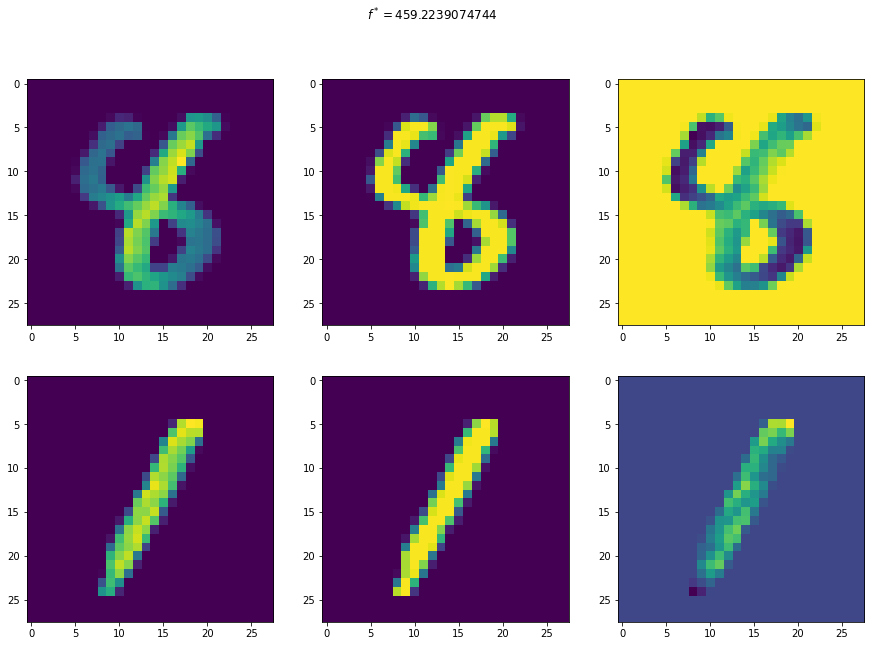

Pair [13168] and [ 7506]


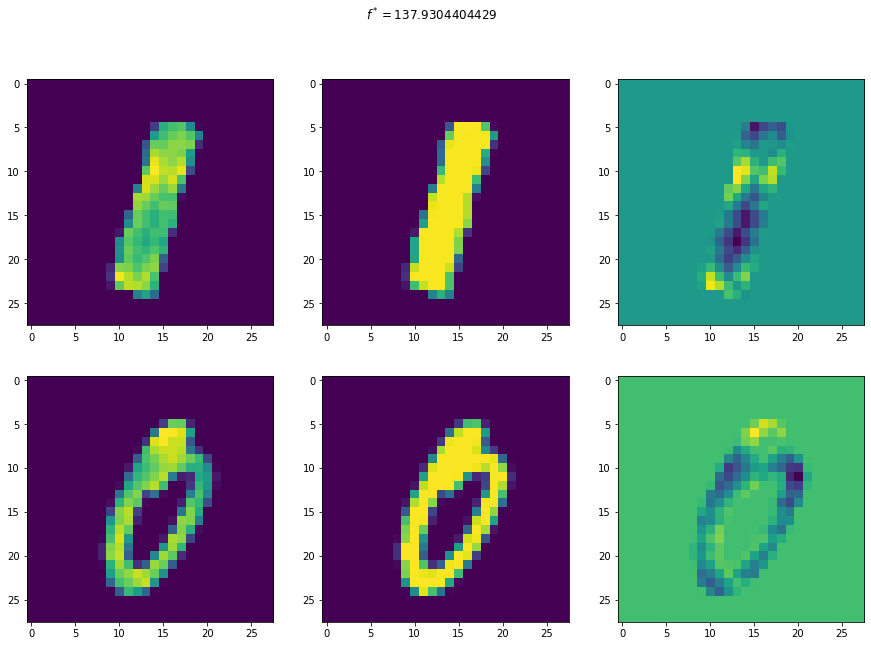

Pair [40816] and [39370]


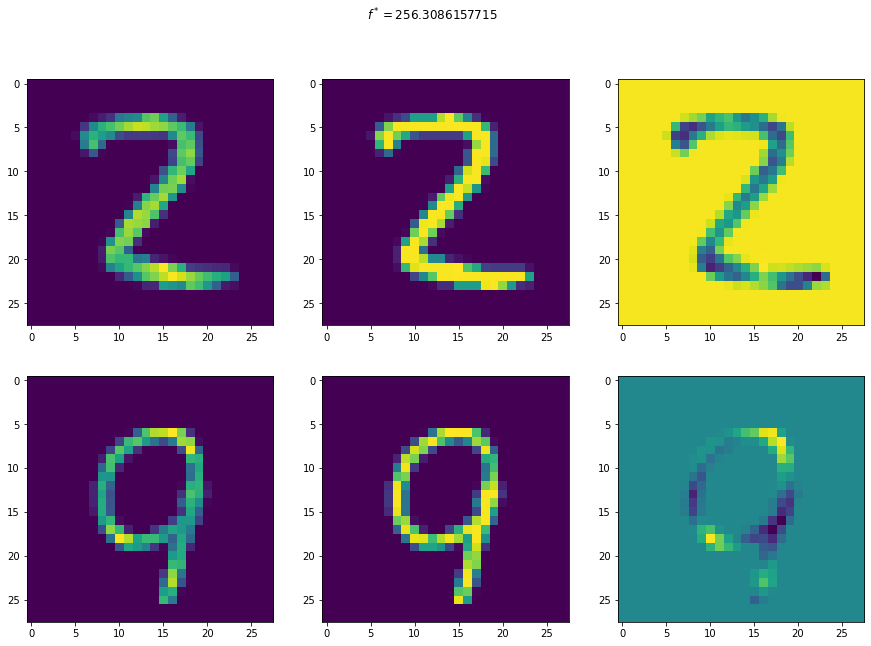

Pair [  846] and [16727]


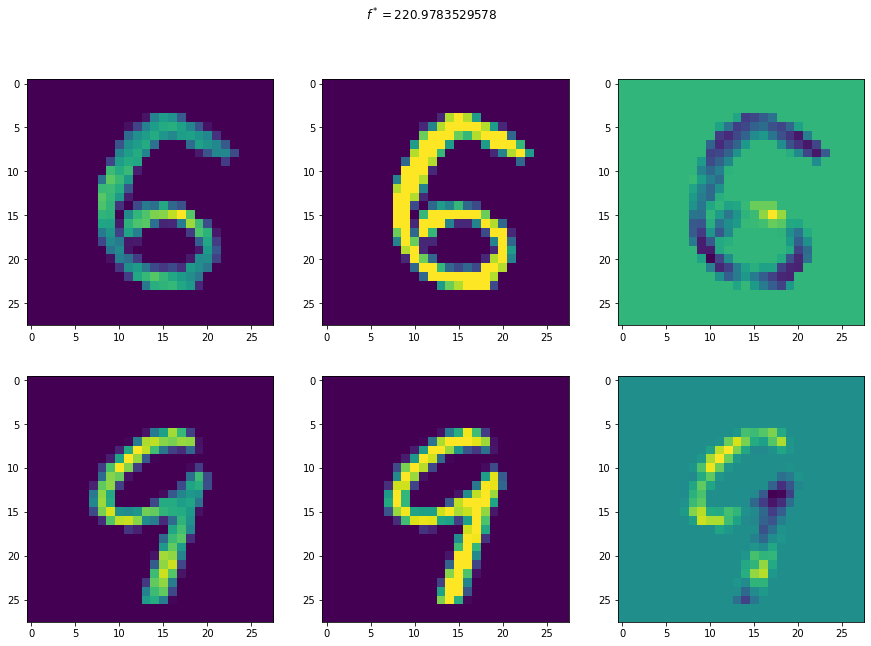

Pair [31169] and [ 7144]


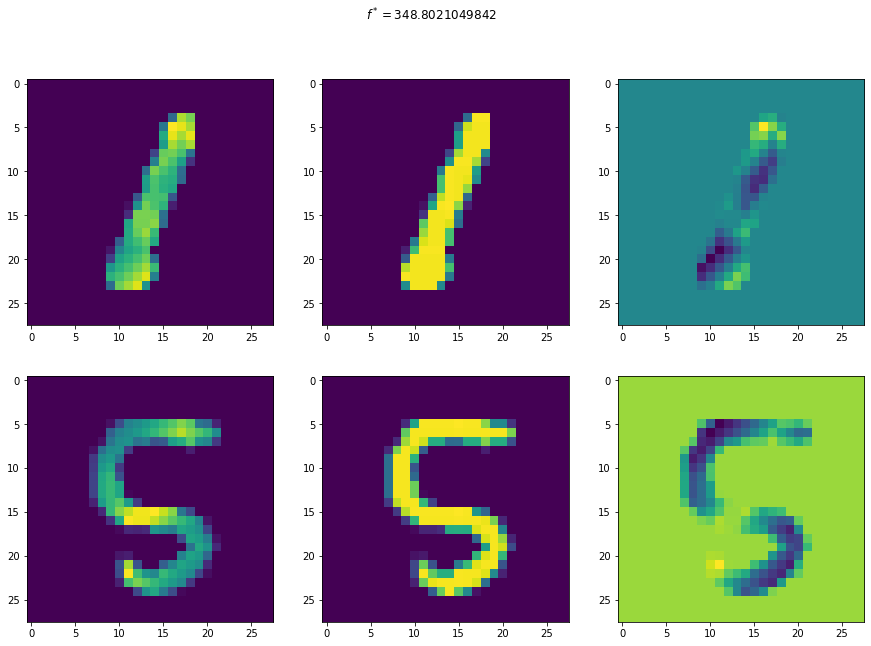

In [10]:
for i, (id1, id2) in enumerate(pairs):
    print(f'Pair [{id1:5d}] and [{id2:5d}]')
    a = x[id1].reshape(-1).astype(np.float64)
    b = x[id2].reshape(-1).astype(np.float64)

    a = a.clip(1e-6)
    b = b.clip(1e-6)

    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    ax[0, 0].imshow(Xs[i].sum(-1).reshape(28, 28))
    ax[0, 1].imshow(a.reshape(28, 28))
    ax[0, 2].imshow(Xs[i].sum(-1).reshape(28, 28) - a.reshape(28, 28))

    ax[1, 0].imshow(Xs[i].sum(0).reshape(28, 28))
    ax[1, 1].imshow(b.reshape(28, 28))
    ax[1, 2].imshow(Xs[i].sum(0).reshape(28, 28) - b.reshape(28, 28))

    plt.suptitle(f'$f^* = {fs[i]:.10f}$')
    plt.show()

In [11]:
logs = []

neps = 10
eps_arr = np.linspace(5.0, 0.5, neps)

kfs, kcs = np.empty((2, npairs, neps))

for i, ((id1, id2), f) in enumerate(zip(pairs, fs)):
    print(f'Pair [{id1:5d}] and [{id2:5d}]')

    a = x[id1].reshape(-1).astype(np.float64)
    b = x[id2].reshape(-1).astype(np.float64)
    
    a = a.clip(1e-6)
    b = b.clip(1e-6)

    uot = UOT(C, a, b, tau)

    for j, eps in enumerate(eps_arr):
        print('Epsilon:', eps)
        # Entropic regularization parameter
        U = calc_U(uot, eps)
        eta = eps / U

        # Convert to Entropic Regularized UOT
        euot = EntRegUOT(C, a, b, tau, eta)

        kfs[i, j] = calc_k_stop(euot, eps)
        print(kfs[i, j])

        # Sinkhorn
        _, log = sinkhorn(euot, 1000)

        logs.append((i, j, log))

        # Find kf
        # kf = log['k_stop']

        # # Find kc
        # f_approx = np.array([
        #     calc_f(uot, calc_B(euot, u, v))
        #     for u, v in zip(log['u'], log['v'])
        # ])
        # kc = np.where(f_approx - f_optimal > eps)[0][-1]

        # kfs[i] = kf
        # kcs[i] = kc + 1

Pair [    3] and [    5]
Epsilon: 5.0
142779.68060154864
Epsilon: 4.5
142779.6806015486
Epsilon: 4.0
142779.68060154864
Epsilon: 3.5
142779.68060154864
Epsilon: 3.0
162112.28578284787
Epsilon: 2.5
198113.72917782323
Epsilon: 2.0
253118.9991525998
Epsilon: 1.5
346909.0253891644
Epsilon: 1.0
540277.923935195


KeyboardInterrupt: 

0 0


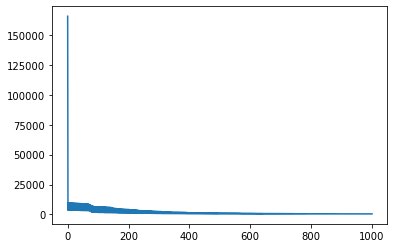

0 1


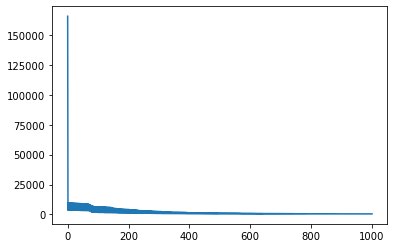

0 2


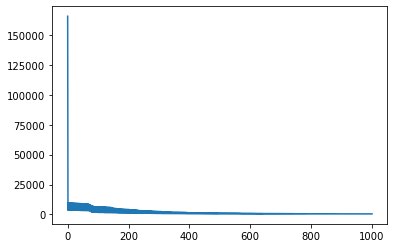

0 3


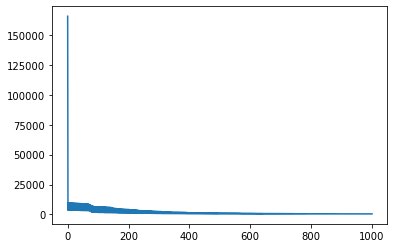

0 4


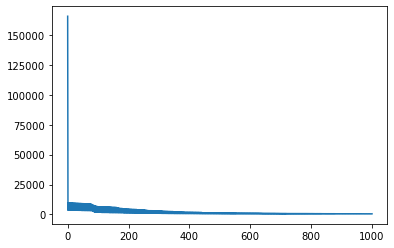

0 5


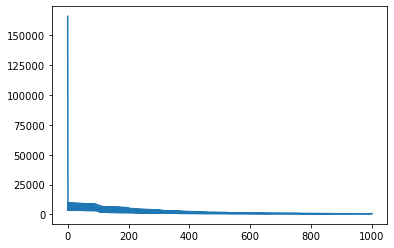

0 6


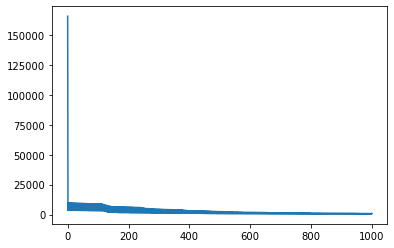

0 7


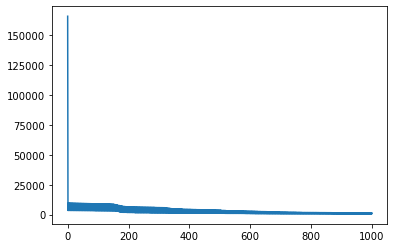

In [22]:
kcs = np.empty(len(logs))

for i, j, log in logs:
    print(i, j)
    # Find kf
    # kf = log['k_stop']
    f_optimal = fs[i]
    eps = eps_arr[j]

    uot = UOT(C, a, b, tau)

    U = calc_U(uot, eps)
    eta = eps / U

        # Convert to Entropic Regularized UOT
    euot = EntRegUOT(C, a, b, tau, eta)

    # Find kc
    f_approx = np.array([
        calc_f(uot, calc_B(euot, u, v))
        for u, v in zip(log['u'], log['v'])
    ])
    kc = np.where(f_approx - f_optimal > eps)[0][-1]
    
    plt.plot(f_approx)
    plt.show()

    # kfs[i] = kf
    kcs[i] = kc + 1

In [21]:
kcs

array([1001.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])